In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [3]:

# Configuração do estilo dos gráficos
sns.set(style="whitegrid")

# Leitura da base de população
populacao_path = '../data/populacao/br_ibge_populacao_municipio.csv'
populacao_df = pd.read_csv(populacao_path)

# Normalização de colunas
populacao_df.columns = populacao_df.columns.str.strip().str.lower()
populacao_df = populacao_df.groupby(['sigla_uf', 'ano']).agg({'populacao': 'sum'}).reset_index()
populacao_df = populacao_df.rename(columns={'sigla_uf': 'UF', 'populacao': 'QUANT_POPULACAO'})
print(populacao_df)

     UF   ano  QUANT_POPULACAO
0    AC  1991         417102.0
1    AC  1992         428006.0
2    AC  1993         437495.0
3    AC  1994         446480.0
4    AC  1995         455242.0
..   ..   ...              ...
859  TO  2018        1555229.0
860  TO  2019        1572866.0
861  TO  2020        1590248.0
862  TO  2021        1607363.0
863  TO  2022        1584306.0

[864 rows x 3 columns]


In [4]:
# Leitura da base de infrações
FOLDER = "../data/infracoes"
PREFIX = "infracoes_"
SUFFIX = ""
EXTENSION = "csv"

FILES = []
for y in range (2019, 2025):
    for m in range (1, 13):
        FILES.append(
            {
                "year": y,
                "month": m,
                "path": f'{FOLDER}/{PREFIX}{y}_{m:02d}{SUFFIX}.{EXTENSION}'
            }
        )

FILES

ENCODINGS = ['utf-8', 'utf-16']
SEPARATORS = [',', ';']
VARIATIONS = ['Codigo da Infracao', 'Codigo_Infracao', 'Cod _Infração', 'COD_INFRACAO']
CORRECT = "INFRACAO"

all_data = []

for file in FILES:
    for encoding in ENCODINGS:
        for separator in SEPARATORS:
            try:
                data = pd.read_csv(file["path"], sep=separator, encoding=encoding)
                
                if len(data.columns) == 1: # Wrong separator
                    continue

                if len(data.columns) > 3: # Each state in a column
                    data = data.drop(0)
                    data.rename(columns={data.columns[0]: CORRECT})
                    data.columns = [CORRECT] + list(data.columns[1:])
                    data = data.melt(id_vars=[CORRECT], var_name="UF", value_name="Quantidade")

                # Normalize columns
                data.columns = [unidecode(col).upper() for col in data.columns]
                for variation in VARIATIONS:
                    adjusted_variation = unidecode(variation).upper()
                    if adjusted_variation in data.columns:
                        data = data.rename(columns={adjusted_variation: CORRECT})
                        break
                data = data[['UF', CORRECT, 'QUANTIDADE']]

                # Adjust numbers
                data['QUANTIDADE'] = data['QUANTIDADE'].fillna(0)
                data['QUANTIDADE'] = data['QUANTIDADE'].astype(str).str.replace('.', '', regex=False).astype(int)

                # Add time identifiers
                data['MES'] = file['month']
                data['ANO'] = file['year']                    
                all_data.append(data)

                break
            except UnicodeError: # Wrong encoding
                continue

# Concatenar as infrações
infracoes_df = pd.concat(all_data)
infracoes_df.head()
print(infracoes_df)

# Normalizar colunas de infrações
infracoes_df.columns = [unidecode(col).upper() for col in infracoes_df.columns]
infracoes_df.rename(columns={'CODIGO_DA_INFRACAO': 'INFRACAO'}, inplace=True)

# Agregar as infrações por município
infracoes_aggregated = infracoes_df.groupby(['UF', 'ANO']).agg({'QUANTIDADE': 'sum'}).reset_index()
infracoes_aggregated = infracoes_aggregated.rename(columns={'UF': 'nome_uf', 'total': 'TOTAL', 'ANO' : 'ano'}).sort_values(by='ano')
infracoes_aggregated

             UF INFRACAO  QUANTIDADE  MES   ANO
0          ACRE     5002          15    1  2019
1          ACRE     5010         827    1  2019
2          ACRE     5029          12    1  2019
3          ACRE     5037          48    1  2019
4          ACRE     5045         514    1  2019
...         ...      ...         ...  ...   ...
6961  TOCANTINS     7773           0   12  2024
6962  TOCANTINS     7781           0   12  2024
6963  TOCANTINS     7790           0   12  2024
6964  TOCANTINS     7803           2   12  2024
6965  TOCANTINS     7811           0   12  2024

[365553 rows x 5 columns]


,nome_uf,ano,QUANTIDADE
0,ACRE,2019,161040
6,ALAGOAS,2019,427190
12,AMAPA,2019,102807
18,AMAZONAS,2019,391196
24,BAHIA,2019,2656588
...,...,...,...
137,RORAIMA,2024,252621
149,SAO PAULO,2024,25307688
131,RONDONIA,2024,385166
155,SERGIPE,2024,439481


In [5]:
# Leitura da base de frotas
FOLDER = "../data/frota"
PREFIX = "frota_"
SUFFIX = ""
EXTENSION = "xls"

FILES = []
for i in range (2004, 2025):
    FILES.append(
        {
            "year": i,
            "path": f'{FOLDER}/{PREFIX}{i}{SUFFIX}.{EXTENSION}'
        }
    )

FILES

all_data = []
previous = []

for file in FILES:    
    excel_file = pd.ExcelFile(file['path'])
    data = pd.read_excel(file['path'], sheet_name=excel_file.sheet_names[-1], skiprows=3, header=0)

    data.columns = (
        data.columns.str.normalize('NFKD')  # Decompose unicode characters
        .str.encode('ascii', errors='ignore')  # Remove non-ASCII characters
        .str.decode('utf-8')  # Decode back to UTF-8
        .str.strip()  # Remove leading/trailing spaces
        .str.lower()  # Convert to lowercase
    )

    data['ano'] = file['year']
    data['mes'] = file['year']

    all_data.append(data)

# Concatenar as frotas
frotas_df = pd.concat(all_data)
# Agregar a frota por município
frotas_aggregated = frotas_df.sort_values('ano').groupby(['uf', 'ano']).agg({'total': 'sum'}).reset_index()
frotas_aggregated = frotas_aggregated.rename(columns={'uf': 'UF', 'total': 'total_veiculos'})

frotas_aggregated


,UF,ano,total_veiculos
0,AC,2004,65692.0
1,AC,2005,73208.0
2,AC,2006,82758.0
3,AC,2007,95292.0
4,AC,2008,111157.0
...,...,...,...
562,TO,2020,754206.0
563,TO,2021,791463.0
564,TO,2022,830733.0
565,TO,2023,874905.0


In [6]:
print(populacao_df['UF'].unique())
print(frotas_aggregated['UF'].unique())
print(infracoes_aggregated['nome_uf'].unique())

['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RN' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
['ACRE' 'ALAGOAS' 'AMAPA' 'AMAZONAS' 'BAHIA' 'CEARA' 'ESPIRITO SANTO'
 'DISTRITO FEDERAL' 'GOIAS' 'MARANHAO' 'MATO GROSSO' 'PARANA' 'PARAIBA'
 'PARA' 'MINAS GERAIS' 'MATO GROSSO DO SUL' 'PERNAMBUCO' 'PIAUI'
 'RIO DE JANEIRO' 'RIO GRANDE DO NORTE' 'RIO GRANDE DO SUL' 'RONDONIA'
 'SANTA CATARINA' 'RORAIMA' 'SAO PAULO' 'SERGIPE' 'TOCANTINS']


In [7]:
uf_mapping = {
    'AC': 'ACRE',
    'AL': 'ALAGOAS',
    'AM': 'AMAPA',
    'AP': 'AP',
    'BA': 'BAHIA',
    'CE': 'CEARA',
    'DF': 'DISTRITO FEDERAL',
    'ES': 'ESPIRITO SANTO',
    'GO': 'GOIAS',
    'MA': 'MARANHAO',
    'MG': 'MINAS GERAIS',
    'MS': 'MATO GROSSO DO SUL',
    'MT': 'MATO GROSSO',
    'PA': 'PARA',
    'PB': 'PARAIBA',
    'PE': 'PERNAMBUCO',
    'PI': 'PIAUI',
    'PR': 'PARANA',
    'RJ': 'RIO DE JANEIRO',
    'RN': 'RIO GRANDE DO NORTE',
    'RO': 'RONDONIA',
    'RR': 'RORAIMA',
    'RS': 'RIO GRANDE DO SUL',
    'SC': 'SANTA CATARINA',
    'SE': 'SERGIPE',
    'SP': 'SAO PAULO',
    'TO': 'TOCANTINS'
}

populacao_df['nome_uf'] = populacao_df['UF'].map(uf_mapping)
frotas_aggregated['nome_uf'] = frotas_aggregated['UF'].map(uf_mapping)
frotas_aggregated['nome_uf'] = frotas_aggregated['UF'].map(uf_mapping)
print(populacao_df)
print(frotas_aggregated)

     UF   ano  QUANT_POPULACAO    nome_uf
0    AC  1991         417102.0       ACRE
1    AC  1992         428006.0       ACRE
2    AC  1993         437495.0       ACRE
3    AC  1994         446480.0       ACRE
4    AC  1995         455242.0       ACRE
..   ..   ...              ...        ...
859  TO  2018        1555229.0  TOCANTINS
860  TO  2019        1572866.0  TOCANTINS
861  TO  2020        1590248.0  TOCANTINS
862  TO  2021        1607363.0  TOCANTINS
863  TO  2022        1584306.0  TOCANTINS

[864 rows x 4 columns]
     UF   ano  total_veiculos    nome_uf
0    AC  2004         65692.0       ACRE
1    AC  2005         73208.0       ACRE
2    AC  2006         82758.0       ACRE
3    AC  2007         95292.0       ACRE
4    AC  2008        111157.0       ACRE
..   ..   ...             ...        ...
562  TO  2020        754206.0  TOCANTINS
563  TO  2021        791463.0  TOCANTINS
564  TO  2022        830733.0  TOCANTINS
565  TO  2023        874905.0  TOCANTINS
566  TO  2024        

In [8]:
# Merge das três bases
merged_data = pd.merge(populacao_df, frotas_aggregated, on=['nome_uf', 'UF', 'ano'], how='inner')
merged_data = pd.merge(merged_data, infracoes_aggregated, on=['nome_uf', 'ano'], how='inner')

# Exclui último ano
merged_data = merged_data[merged_data['ano'] < merged_data['ano'].max()]

# Renomear colunas para facilitar análise
merged_data.rename(columns={'POPULACAO': 'POPULACAO', 'QUANTIDADE': 'TOTAL_INFRACOES'}, inplace=True)

merged_data

,UF,ano,QUANT_POPULACAO,nome_uf,total_veiculos,TOTAL_INFRACOES
0,AC,2019,881935.0,ACRE,292659.0,161040
1,AC,2020,894470.0,ACRE,306258.0,15139
2,AC,2021,906876.0,ACRE,320173.0,42628
4,AL,2019,3337357.0,ALAGOAS,889900.0,427190
5,AL,2020,3351543.0,ALAGOAS,930933.0,55615
...,...,...,...,...,...,...
97,SP,2020,46289333.0,SAO PAULO,30778960.0,5755666
98,SP,2021,46649132.0,SAO PAULO,31455473.0,18492126
100,TO,2019,1572866.0,TOCANTINS,721803.0,320113
101,TO,2020,1590248.0,TOCANTINS,754206.0,107232


In [9]:
# Renomear colunas para facilitar análise
merged_data.rename(columns={'QUANT_POPULACAO': 'populacao', 'TOTAL_INFRACOES': 'total_infracoes'}, inplace=True)

merged_data

,UF,ano,populacao,nome_uf,total_veiculos,total_infracoes
0,AC,2019,881935.0,ACRE,292659.0,161040
1,AC,2020,894470.0,ACRE,306258.0,15139
2,AC,2021,906876.0,ACRE,320173.0,42628
4,AL,2019,3337357.0,ALAGOAS,889900.0,427190
5,AL,2020,3351543.0,ALAGOAS,930933.0,55615
...,...,...,...,...,...,...
97,SP,2020,46289333.0,SAO PAULO,30778960.0,5755666
98,SP,2021,46649132.0,SAO PAULO,31455473.0,18492126
100,TO,2019,1572866.0,TOCANTINS,721803.0,320113
101,TO,2020,1590248.0,TOCANTINS,754206.0,107232


In [10]:
# Print para verificar a estrutura dos dados
print(merged_data.head())

   UF   ano  populacao  nome_uf  total_veiculos  total_infracoes
0  AC  2019   881935.0     ACRE        292659.0           161040
1  AC  2020   894470.0     ACRE        306258.0            15139
2  AC  2021   906876.0     ACRE        320173.0            42628
4  AL  2019  3337357.0  ALAGOAS        889900.0           427190
5  AL  2020  3351543.0  ALAGOAS        930933.0            55615


In [11]:
# Análise da relação entre a quantidade de veículos, população e infrações
X = merged_data.drop('total_veiculos', axis=1)
y = merged_data['total_veiculos']

df = merged_data

print(X)
print(y)

     UF   ano   populacao    nome_uf  total_infracoes
0    AC  2019    881935.0       ACRE           161040
1    AC  2020    894470.0       ACRE            15139
2    AC  2021    906876.0       ACRE            42628
4    AL  2019   3337357.0    ALAGOAS           427190
5    AL  2020   3351543.0    ALAGOAS            55615
..   ..   ...         ...        ...              ...
97   SP  2020  46289333.0  SAO PAULO          5755666
98   SP  2021  46649132.0  SAO PAULO         18492126
100  TO  2019   1572866.0  TOCANTINS           320113
101  TO  2020   1590248.0  TOCANTINS           107232
102  TO  2021   1607363.0  TOCANTINS           230385

[78 rows x 5 columns]
0        292659.0
1        306258.0
2        320173.0
4        889900.0
5        930933.0
          ...    
97     30778960.0
98     31455473.0
100      721803.0
101      754206.0
102      791463.0
Name: total_veiculos, Length: 78, dtype: float64


In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Anos para predicao
future_years = [2021, 2022, 2023, 2024]
predictions = []

# Para cada UF
for uf in df["UF"].unique():
    df_uf = df[df["UF"] == uf].sort_values("ano")

    # Treina modelos
    models = {}
    for target in ["total_veiculos", "total_infracoes"]:
        X = df_uf[["ano", "populacao"]] 
        y = df_uf[target]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)

        models[target] = model 

    # Predição
    for year in future_years:
        # Estimar população
        last_year, last_pop = df_uf.iloc[-1][["ano", "populacao"]]
        avg_growth = df_uf["populacao"].pct_change().mean()
        future_pop = last_pop * (1 + avg_growth) ** (year - last_year)

        # Valores iniciais para predição
        X_future =  pd.DataFrame({"ano": [year], "populacao": [future_pop]}) 

        # Predição para veículos e infrações
        pred_veiculos = models["total_veiculos"].predict(X_future)[0]
        pred_infracoes = models["total_infracoes"].predict(X_future)[0]
        predictions.append({"UF": uf, "ano": year, "populacao": future_pop, "total_veiculos": pred_veiculos, "total_infracoes": pred_infracoes})


df_predictions = pd.DataFrame(predictions)
df_predictions

,UF,ano,populacao,total_veiculos,total_infracoes
0,AC,2021,9.068760e+05,314761.95,40576.79
1,AC,2022,9.196098e+05,314761.95,40576.79
2,AC,2023,9.325224e+05,314761.95,40576.79
3,AC,2024,9.456162e+05,314761.95,40576.79
4,AL,2021,3.365351e+06,962468.75,300130.23
...,...,...,...,...,...
99,SP,2024,4.776608e+07,31189459.33,15312810.65
100,TO,2021,1.607363e+06,777175.47,199157.03
101,TO,2022,1.624894e+06,777175.47,199157.03
102,TO,2023,1.642617e+06,777175.47,199157.03


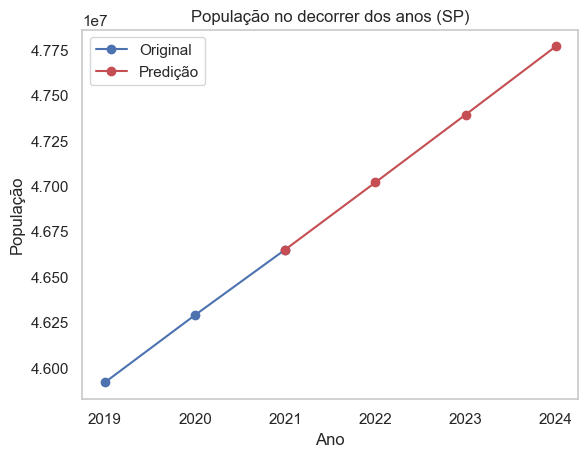

In [30]:
import matplotlib.pyplot as plt

uf = "SP"

df_original = df[df["UF"] == uf]
df_predicted = df_predictions[df_predictions["UF"] == uf]


plt.plot(df_original["ano"], df_original["populacao"], 'bo-', label="Original")
plt.plot(df_predicted["ano"], df_predicted["populacao"], 'ro-', label="Predição")

plt.xlabel("Ano")
plt.ylabel("População")
plt.title(f"População no decorrer dos anos ({uf})")
plt.legend()
plt.grid()

plt.show()

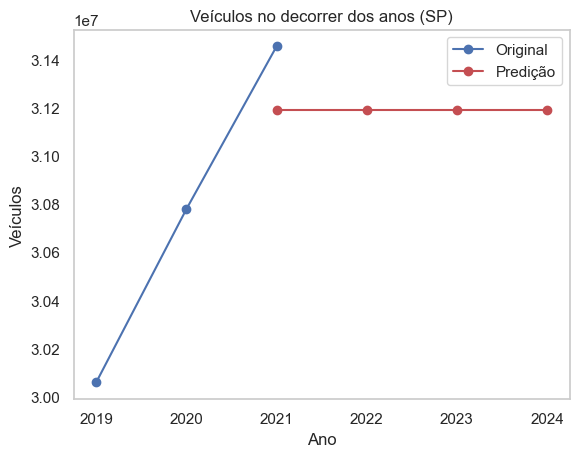

In [31]:
df_original = df[df["UF"] == uf]
df_predicted = df_predictions[df_predictions["UF"] == uf]


plt.plot(df_original["ano"], df_original["total_veiculos"], 'bo-', label="Original")
plt.plot(df_predicted["ano"], df_predicted["total_veiculos"], 'ro-', label="Predição")

plt.xlabel("Ano")
plt.ylabel("Veículos")
plt.title(f"Veículos no decorrer dos anos ({uf})")
plt.legend()
plt.grid()

plt.show()